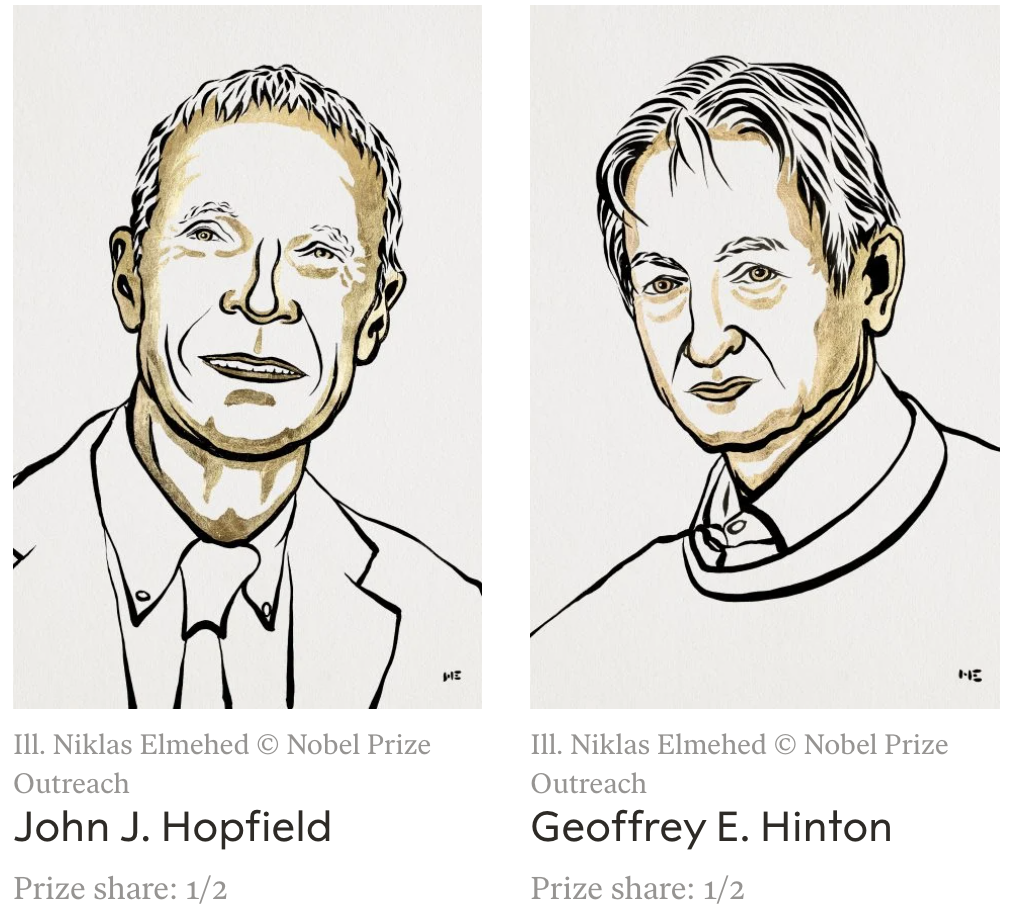

# Hopfield Nobel Nets
We will answer the following questions using code that implements these networks using **TensorFlow's Keras** API
* How do Hopfield networks work?
* What makes them different from conventional networks?
* What can we expect from them?

Reference:

https://www.nobelprize.org/prizes/physics/2024/summary/

## Overview and Difference with Classical Neural Nets
A Hopfield network is a type of recurrent neural network where neurons are connected to each other, and it works as an associative memory system. It can store patterns (memories) and retrieve the closest one when given incomplete or noisy input. Unlike classical networks which are designed for input-output mappings and often used for classification, Hopfield networks focus on stabilizing to a stored pattern.

👆Furthmore, Hopfield networks are **not** typically trained using gradient descent.

## Where to use Hopfield Nobel Nets ?
Hopfield networks are not specialized for time series prediction. They are primarily designed for associative memory tasks, such as pattern recognition or reconstruction. Hopfield networks work well when you need to retrieve a stored pattern from partial or noisy input but are not suited for handling sequential data with time dependencies.

##How does it works ?
Here’s a simple example of how a Hopfield network works:

Problem: Let's say you want to store and retrieve binary patterns in a Hopfield network. We store the following two binary patterns:

```
Pattern 1: [1, -1, 1, -1]
Pattern 2: [-1, 1, -1, 1]

```


**Steps:**

* Initialization: The Hopfield network has 4 neurons because each pattern has 4 elements. Each neuron can be in one of two states: 1 or -1.


* Training: You adjust the weights between neurons so that the network stores these two patterns. The weights are updated using **Hebbian learning**:

$$
w_{ij} = \frac{1}{n} \sum_p x_i^p \cdot x_j^p
$$

where $x_i^p$ is the $i$-th neuron of the $p$-th pattern, and $n$ is the number of patterns.


Recall: If you input a noisy or incomplete version of one of the stored patterns (like `[1, -1, 1, 1]`), the network updates the neuron states until it settles into a stable state that is one of the stored patterns (in this case, it would likely converge to `[1, -1, 1, -1]`). The network stabilizes at one of the stored patterns by adjusting the neurons' states until they match a memory the network was trained on.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input
import matplotlib.pyplot as plt

Patterns: Two simple binary patterns are stored `([1, -1, 1, -1] , [-1, 1, -1, 1])`.

In [ ]:
# Training patterns (associative memory)
if False:
  patterns = np.array([[1, -1, 1, -1],
                     [-1, 1, -1, 1]])
  noisy_input = np.array([[1, -1, 1, 1]])  # Slightly altered pattern (last digit of 1st pattern)
else:
  patterns = np.array([[1, -1, 1],
                     [-1, 1, -1]])
  noisy_input = np.array([[1, -1, -1]])  # Slightly altered pattern (last digit of 1st pattern)

### Training Step
We calculate the weight matrix using Hebbian learning (outer product of patterns). In Hebbian learning, the idea is that **"neurons that fire together, wire together."**  The weight between two neurons is increased proportionally to their activations.

The choice of the **outer product** is key because it creates a full pairwise connection matrix—all neurons influence each other, allowing the network to store patterns by reinforcing connections between all neuron pairs.

A dot product would only produce a single scalar value, capturing similarity but not the necessary pairwise connections for each neuron. The outer product is thus essential for creating the complete weight matrix for pattern storage



❌`Keras` does not perform any learning in the traditional sense (like backpropagation and gradient descent)❌.

#### Key Steps
**Hebbian Learning**: The weight matrix is built by summing the outer products of the training patterns.

**Reconstruction**: The network uses the weight matrix to update neuron states and recover stored patterns from noisy inputs.

#### Python code for Hebbian Learning
Here is the Python code implementing these steps :

In [ ]:
# Hopfield-like update rule: Hebbian learning
def hebbian_learning(patterns):
    num_neurons = patterns.shape[1]
    weights = np.zeros((num_neurons, num_neurons))
    for p in patterns:
        weights += np.outer(p, p)

    if False:
      np.fill_diagonal(weights, 0)  # No self-connections
    else:
      weights = (weights / patterns.shape[0]) - np.eye(num_neurons)
    return weights

##### Regularize the Weights
**Problem**: Large noise can disturb the network's weight matrix.

**Solution**: Regularize the weights by adding a small regularization term to the weight update rule. This helps prevent the network from being overly influenced by any single pattern.

**Tip**: try both learning rules (`hebbian_learning` vs `hebbian_learning_with_regularization`) and compare the results...

In [ ]:
def hebbian_learning_with_regularization(patterns, reg_strength=0.01):
    num_neurons = patterns.shape[1]
    weights = np.zeros((num_neurons, num_neurons))
    for p in patterns:
        weights += np.outer(p, p)
    weights = (weights / patterns.shape[0]) - reg_strength * np.eye(num_neurons)
    return weights

## Exemple 1 : Recover Binary digits

In [ ]:
print(patterns)

In [ ]:
# Initialize the network weights
weights = hebbian_learning_with_regularization(patterns)

In [ ]:
print('shape : ',weights.shape)
print()
print(weights)

In [ ]:
def build_model(weights , activation  = 'tanh'):
  # Build a minimal Keras model with custom weight initialization
  model = Sequential([
    Input(shape=(weights.shape[0],)),
    Dense(weights.shape[0], activation = activation, use_bias = False)])
   # Set the weights learned by Hebbian learning
  model.layers[0].set_weights([weights])
  return model

In [ ]:
model = build_model(weights)

###Inference Step :

A noisy pattern is input, and the model recovers the closest stored pattern using a simple thresholding function.

In [ ]:
# Test with a noisy pattern

# Run inference
output = model.predict(noisy_input)
output_sign = np.sign(output)  # Apply binary thresholding to match stored patterns

print("Output:", output_sign)
print("Closest stored pattern:", patterns[np.argmin(np.linalg.norm(patterns - output_sign, axis=1))])

## Exemple 2 : Recover Letters

I take inspiration here:

https://github.com/ccd97/hello_nn/blob/master/Hopfield-Network/np_hnn_reconstruction.ipynb

In this interesting notebook (above), Hopfield Nobel Nets are implemented in pure `Numpy` without Keras and then used `np.sign` instead of `tanh` function.
`np.sign` is not differentiable, meaning you can't use gradient-based optimization with this activation, but for binary discrete tasks, `np.sign` is better.

In [ ]:
# Function to plot real, distorted, and reconstructed images
def plot_images(images, title, no_i_x, no_i_y=3):
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle(title)
    images = np.array(images).reshape(-1, 5, 5)
    #images = np.pad(images, ((0, 0), (1, 1), (1, 1)), 'constant', constant_values=-1)
    for i in range(no_i_x):
        for j in range(no_i_y):
            ax = fig.add_subplot(no_i_x, no_i_y, no_i_x * j + (i + 1))
            ax.matshow(images[no_i_x * j + i], cmap="gray")
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

            if j == 0 and i == 0:
                ax.set_title("Real")
            elif j == 1 and i == 0:
                ax.set_title("Distorted")
            elif j == 2 and i == 0:
                ax.set_title("Reconstructed")

Pattern Storage: The six provided letter patterns are stored in the Hopfield network using Hebbian learning.


In [ ]:
# Dummy data: patterns for letters P, Y, T, H, O, N
perfect_data = {
    "P": [1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1],
    "Y": [1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1],
    "T": [1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1],
    "H": [1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1],
    "O": [1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
    "N": [1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1]
}

In [ ]:
type(perfect_data)

In [ ]:
# Convert the dictionary into a numpy array
patterns = np.array(list(perfect_data.values()))

### Training Network
The weights are calculated by the outer product of the patterns, and a simple Keras model with a dense layer is initialized with these weights.


In [ ]:
# Initialize the network weights
weights = hebbian_learning_with_regularization(patterns)

In [ ]:
weights.shape

In [ ]:
model = build_model(weights)

In [ ]:
letter = 'H'

In [ ]:
# Distorted test input (modify an existing pattern)
distorted_pattern = np.copy(perfect_data[letter])
distorted_pattern[5] = -1  # Introduce noise

###Inference
A noisy (distorted) version of the letter "P" is passed to the network to test its ability to recover the original pattern.

In [ ]:
# Run inference
reconstructed = model.predict(np.array([distorted_pattern]))
reconstructed_sign = np.sign(reconstructed)

### Visualization
The plot_images function visualizes the original, distorted, and reconstructed patterns in a grid.

In [ ]:
# Prepare images for plotting (real, distorted, reconstructed)
real_image = perfect_data[letter]
distorted_image = distorted_pattern
reconstructed_image = reconstructed_sign[0]

plot_images([real_image, distorted_image, reconstructed_image], "Hopfield Network Results", no_i_x=1)

plt.show()

### More noisy data

In [ ]:
import random
# Heavily distort the pattern by flipping multiple bits
def add_noise(pattern, num_flips):
    distorted_pattern = np.copy(pattern)
    flip_indices = random.sample(range(len(pattern)), num_flips)
    for idx in flip_indices:
        distorted_pattern[idx] *= -1  # Flip the bit
    return distorted_pattern

In [ ]:
letter = 'O'
# Distorted test input (add heavy noise to an existing pattern)
distorted_pattern = add_noise(perfect_data[letter], num_flips=6)  # Flip random bits

In [ ]:
# Run inference
reconstructed = model.predict(np.array([distorted_pattern]))
reconstructed_sign = np.sign(reconstructed)

In [ ]:
# Prepare images for plotting (real, distorted, reconstructed)
real_image = perfect_data[letter]
distorted_image = distorted_pattern
reconstructed_image = reconstructed_sign[0]
# match reconstructed with the closest stored pattern
closest_image = patterns[np.argmin(np.linalg.norm(patterns - reconstructed_image, axis=1))]

plot_images([real_image, distorted_image, reconstructed_image], "Hopfield Network Results", no_i_x=1)

In [ ]:
# match reconstructed with the closest stored pattern
plot_images([real_image, distorted_image, closest_image], "Hopfield Network Results", no_i_x=1)